In [51]:
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm
import pymorphy2
import string
import joblib
import collections

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Таблица с исходными и исправленными запросами

- orig - исходный запрос
- new - исправленный запрос
- deleted - удаленные из исходного запроса слова
- added - добавленные в исходный запрос слова

In [5]:
queries_df = pd.read_csv('queries_fixed.csv', usecols=['нулевой запрос', 'успешный запрос', 'что выкинули', 'что добавили'])
queries_df.columns = ['old', 'new', 'deleted', 'added']
queries_df = queries_df[(queries_df['old'] == queries_df['old']) & (queries_df['new'] == queries_df['new'])]
print(queries_df.shape)
queries_df['old'] = queries_df['old'].apply(lambda sent: sent.strip())
queries_df['new'] = queries_df['new'].apply(lambda sent: sent.strip())
queries_df.tail()

(4410, 4)


,old,new,deleted,added
4412,является ли нарушением законодательства несоот...,является ли нарушением законодательства несоот...,его на и выполнение создания в пл отраженными,NaN
4413,является ли несовместное проживание с детьми п...,имеет ли право требовать пенсионный фонд при н...,отказа детьми поводом с в проживание является ...,назначении фонд имеет совместном право прожива...
4414,является ли объектами налогообложения налогом ...,пожарная сигнализация налог на имущество в 2019,и объектами видеонаблюдения ли система являетс...,налог
4415,является ли основанием для увольнения руководи...,типовая форма договора с руководителем федерал...,указанием увольнения задолженности ли автономн...,форма руководителем договора типовая
4416,#ERROR!,- ткань должна соответствовать требованиям ГОС...,NaN,ГОСТ 29298-2005 Ткани хлопчатобумажные и смеша...


#### Cтоп-слова

In [6]:
exclude_words = []

exclude_lines = open("exclude_words.txt", "r", encoding='cp866').readlines()
for line in exclude_lines:
    line = line.replace('\n', '')
    line = line.split('=')[-1]
    line = line.translate(str.maketrans('', '', string.punctuation))
    #print(line)
    exclude_words.extend(line.split())

exclude_words = list(set(exclude_words))
exclude_words = [word.lower() for word in exclude_words]
len(exclude_words)

336

#### Нормализуем запросы

- norm_old
- norm_new

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
all_norm_old = []
all_norm_new = []

for row in tqdm(queries_df.itertuples(), total=queries_df.shape[0]):
    norm_old = ''
    row_old = row.old.translate(str.maketrans('', '', string.punctuation))
    for word in row_old.split():
        this_normform = morph.parse(word)[0].normal_form
        if this_normform.lower() not in exclude_words:
            norm_old += this_normform + ' '
    norm_old = norm_old[:-1]
    all_norm_old.append(norm_old)
        
    norm_new = ''
    row_new = row.new.translate(str.maketrans('', '', string.punctuation))
    for word in row_new.split():
        this_normform = morph.parse(word)[0].normal_form
        if this_normform.lower() not in exclude_words:
            norm_new += this_normform + ' '
    norm_new = norm_new[:-1]
    all_norm_new.append(norm_new)

queries_df['norm_old'] = all_norm_old
queries_df['norm_new'] = all_norm_new

queries_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4410/4410 [00:25<00:00, 173.60it/s]


,old,new,deleted,added,norm_old,norm_new
0,Постановление Правительства РМ16.02.2008 г № 7,Постановление Правительства РМ от 16.02.200...,РМ16.02.2008,16.02.2008 РМ от,постановление правительство рм16022008 год 7,постановление правительство рм 16022008 год 7
1,"Действующие тарифы на перевозку пассажиров, ру...","на перевозку пассажиров, ручной клади и живности",тарифы Действующие,NaN,действующий тариф перевозка пассажир ручной кл...,перевозка пассажир ручной класть живность
2,постановление о мерах социальной поддержки...,постановление о мерах социальной поддержки...,удмуртия,NaN,постановление мера социальный поддержка работн...,постановление мера социальный поддержка работн...
3,практические рекомендации по организации внут...,практические рекомендации по организации внут...,стоматология,NaN,практический рекомендация организация внутренн...,практический рекомендация организация внутренн...
4,РЕШЕНИЕ от 1 августа 2018 г. N 223ФЗ-556/18,N 18/44/105/918,РЕШЕНИЕ августа от 223ФЗ-556/18 2018 г. 1,18/44/105/918,решение 1 август 2018 год 223фз55618,1844105918


Что получилось

In [9]:
all_normforms = all_norm_old
all_normforms.extend(all_norm_new)
len(all_normforms), all_normforms[:10]

(8820,
 ['постановление правительство рм16022008 год 7',
  'действующий тариф перевозка пассажир ручной класть живность',
  'постановление мера социальный поддержка работник муниципальный учреждение удмуртия',
  'практический рекомендация организация внутренний контроль качество безопасность медицинский деятельность медицинский организация стоматология',
  'решение 1 август 2018 год 223фз55618',
  'внесение постановление глава администрация губернатор краснодарский край 20 январь 2017 год 48 утверждение порядок сбор число раздельный твёрдый коммунальный отход краснодарский край',
  '04052011 99фp',
  '1151006 налоговый декларация налог прибыль 2019 место учёт учреждение оказывать социальный услуга',
  '17 декабря№382 внесение',
  '19032012 161523501 порядок заполнение граф 4 счетафактура'])

### TF IDF

In [10]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(all_normforms)
word_count_vector.shape

(8820, 9523)

In [11]:
word_count_vector1 = word_count_vector.copy()
for i in range(73):
    if i == 0:
        word_freq_array = word_count_vector1[:10000].toarray().sum(axis=0)
    else:
        word_freq_array = np.vstack((word_freq_array,word_count_vector1[:10000].toarray().sum(axis=0)))
    word_count_vector1 = word_count_vector1[10000:]
all_word_freq = word_freq_array.sum(axis=0)
len(all_word_freq)

9523

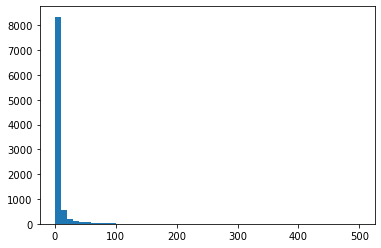

In [12]:
#распределение частот слов
_=plt.hist(list(all_word_freq),range=[0,500],bins=50)

In [13]:
words = cv.get_feature_names()
len(words)

9523

In [14]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

all_normforms_transformed = cv.transform(all_normforms)
all_normforms_tfidf = tfidf_transformer.transform(all_normforms_transformed)

In [15]:
tfidf_transformer.idf_.shape

(9523,)

In [16]:
all_normforms_tfidf.shape

(8820, 9523)

### word2vec


In [17]:
sent_split = [nf.split() for nf in all_normforms]
phrases = Phrases(sent_split, min_count=30)
bigram = Phraser(phrases)
sentences = bigram[sent_split]

In [18]:
w2v = Word2Vec(min_count=1, # Ignores all words with total absolute frequency lower than this
                     window=2,     # The maximum distance between the current and predicted word within a sentence.
                     size=300,     # Dimensionality of the feature vectors.
                     sample=6e-5,  # The threshold for configuring which higher-frequency words are randomly downsampled.
                                   # Highly influencial.
                     alpha=0.03,   # The initial learning rate
                     min_alpha=0.0007, 
                     negative=0) # If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown.
                                  # If set to 0, no negative sampling is used.

In [19]:
w2v.build_vocab(sentences)

In [20]:
w2v.train(sentences, total_examples=w2v.corpus_count, # total_examples - Count of sentences
                epochs=30, report_delay=1)

(1108976, 1983270)

In [21]:
# make the model more memory-efficient
w2v.init_sims(replace=True)

In [22]:
len(w2v.wv.vocab.items())

9651

In [23]:
w2v.wv.most_similar(positive='кодекс')

[('4тэр', 0.22023484110832214),
 ('мрот', 0.1957094520330429),
 ('авиарейс', 0.19348780810832977),
 ('ф09518110с3', 0.18779496848583221),
 ('автобус', 0.1875634491443634),
 ('попадать', 0.1866508275270462),
 ('307', 0.18638400733470917),
 ('№24н', 0.18506290018558502),
 ('конкретизация', 0.18186363577842712),
 ('4213330201', 0.18074911832809448)]

In [24]:
index2word_set = set(w2v.wv.index2word)

# for sentences
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [29]:
# чем эта величина больше, тем сильнее различаются предложения
def sentence_difference(sent1, sent2):
    s1_afv = avg_feature_vector(sent1, model=w2v, num_features=300, index2word_set=index2word_set)
    s2_afv = avg_feature_vector(sent2, model=w2v, num_features=300, index2word_set=index2word_set)
    dif = spatial.distance.cosine(s1_afv, s2_afv)
    return dif*10


In [30]:
sentence_difference('постановление правительство рм16.02.2008 год № 7',
                    'постановление правительство рм16.02.2008')

2.782154679298401

In [31]:
sentence_difference('постановление правительство рм16.02.2008 год № 7',
                    'постановление о мера социальный поддержка работник муниципальный учреждение удмуртия')

8.700469732284546

In [32]:
sentence_difference('постановление правительство рм16.02.2008 год № 7',
                    'действующий тариф на перевозка пассажир ручной класть и живность')

10.844635963439941

### Бинарные признаки

- type
- source
- territory

In [33]:
type_words = []

type_lines = open("type_words.txt", "r", encoding='cp866').readlines()
for line in type_lines:
    line = line.replace('\n', '')
    line = line.split('=')[-1]
    line = line.translate(str.maketrans('', '', string.punctuation))
    #print(line)
    type_words.extend(line.split())

type_words = list(set(type_words))
type_words = [word.lower() for word in type_words if len(word) > 2]
len(type_words)

347

In [34]:
source_words = []

source_lines = open("source_words.txt", "r", encoding='cp866').readlines()
for line in source_lines:
    line = line.replace('\n', '')
    line = line.split('=')[-1]
    line = line.translate(str.maketrans('', '', string.punctuation))
    source_words.extend(line.split())
    
source_words = list(set(source_words))
source_words = [word.lower() for word in source_words if len(word) > 2]
len(source_words)

2290

In [35]:
terr_words = []

terr_lines = open("territory_words.txt", "r", encoding='cp866').readlines()
for line in terr_lines:
    line = line.replace('\n', '')
    line = line.split('=')[-1]
    line = line.translate(str.maketrans('', '', string.punctuation))
    terr_words.extend(line.split())
    
terr_words = list(set(terr_words))
terr_words = [word.lower() for word in terr_words if len(word) > 2]
len(terr_words)

258

Пересечения списков слов

In [36]:
print(set.intersection(set(type_words), set(terr_words)))

{'муниципальный'}


In [37]:
print(set.intersection(set(source_words), set(type_words)))

{'российского', 'практическая', 'строительстве', 'материалы', 'труда', 'журнал', 'материалов', 'правовой', 'цен', 'государственный', 'бухгалтерские', 'налоговая', 'республиканский', 'нормативные', 'федеральный', 'конституционный', 'бюллетень', 'работ', 'безопасности', 'законодательный', 'строительству', 'дорожная', 'законодательства', 'судебный', 'охране', 'уставный', 'правового'}


In [38]:
print(set.intersection(set(source_words), set(terr_words)))

{'хакасия', 'центральный', 'калмыкия', 'краснодарский', 'тыва', 'саха', 'область', 'еврейская', 'российская', 'красноярский', 'ставропольский', 'магаданская', 'курская', 'карелия', 'сахалинская', 'мордовия', 'северная', 'дагестан', 'республика', 'марий', 'якутия', 'комипермяцкий', 'устьордынский', 'алтайский', 'адыгея', 'кировский', 'алтай', 'таймырский', 'ненецкий', 'хабаровский', 'новая', 'бурятский', 'московская', 'округ', 'автономный', 'спб', 'ингушетия', 'осетияалания', 'агинский', 'башкортостан', 'чеченская', 'камчатский', 'федерация', 'корякский', 'чукотский', 'приморский', 'край', 'московский', 'коми', 'эвенкийский', 'татарстан', 'пермский', 'автономная', 'бурятия'}


##### Части речи

In [39]:
def part_of_speech(word):
    p = morph.parse(word)[0]
    pos = p.tag.POS
    
    res = [0,0,0,0,0,0,0,0,0,0,0,0]
    if pos == 'NOUN':
        res = [1,0,0,0,0,0,0,0,0,0,0,0]
    if pos == 'ADJF' or pos == 'ADJS':
        res = [0,1,0,0,0,0,0,0,0,0,0,0]
    if pos == 'COMP':
        res = [0,0,1,0,0,0,0,0,0,0,0,0]
    if pos == 'VERB':
        res = [0,0,0,1,0,0,0,0,0,0,0,0]
    if pos == 'INFN':
        res = [0,0,0,0,1,0,0,0,0,0,0,0]
    if pos == 'PRTF' or pos == 'PRTS':
        res = [0,0,0,0,0,1,0,0,0,0,0,0]
    if pos == 'GRND':
        res = [0,0,0,0,0,0,1,0,0,0,0,0]
    if pos == 'NUMR':
        res = [0,0,0,0,0,0,0,1,0,0,0,0]
    if pos == 'ADVB':
        res = [0,0,0,0,0,0,0,0,1,0,0,0]
    if pos == 'NPRO':
        res = [0,0,0,0,0,0,0,0,0,1,0,0]
    if pos == 'PRED':
        res = [0,0,0,0,0,0,0,0,0,0,1,0]
    if pos == 'PREP' or pos == 'CONJ' or pos == 'PRCL' or pos == 'INTJ':
        res = [0,0,0,0,0,0,0,0,0,0,0,1]
        
    return res

### final data table

In [40]:
feature_names = cv.get_feature_names()
'постановление' in feature_names

True

In [41]:
len(feature_names)

9523

In [42]:
word_features_table = []
part_of_speech_col = []
row_names_list = []
Y = []

for it, q_row in tqdm(queries_df.iterrows(), total=queries_df.shape[0]):
    old = q_row.old
    new = q_row.new
    deleted = [word for word in old.split() if word not in new.split()]
    
    tfidf_row = pd.DataFrame(all_normforms_tfidf[it].T.todense(), index=feature_names, columns=["tfidf"])
    #print(tfidf_row)
    for word in old.split():
        row_names_list.append(word+'_'+str(it)+'_'+old) # row name
            
        Y.append(1 if word in deleted else 0) # Y
            
        features_row = []
        
        try:
            features_row.append(tfidf_row.loc[word.lower()].tolist()[0]) # tfidf
        except:
            features_row.append(0)
            
        try:
            features_row.append(idf_df.loc[word.lower()].tolist()[0]) # idf
        except:
            features_row.append(0)
            
        features_row.append(sentence_difference(old, old.replace(word, '').replace('  ', ' '))) # w2v_imp
            
        features_row.append(word.lower() in type_words) # type
        features_row.append(word.lower() in source_words) # source
        features_row.append(word.lower() in terr_words) # territory
            
        features_row.append(str(word).lower().isdigit()) # only digits
        features_row.append(str(word).lower().isalpha()) # only letters
        features_row.append(str(word).lower().isalnum()) # only letters and digits (no symbols)
        
        features_row.append(len(old.split())) # N of words in sentence
            
        part_of_speech_col.append(part_of_speech(word)) # part of speech (12 columns)
        
        word_features_table.append(features_row)
    
word_features_df = pd.DataFrame(word_features_table, index=row_names_list,
                                columns=['tfidf', 'idf', 'w2v_imp', 'type', 'source', 'terr',
                                        'digit', 'letter', 'no_sym', 'sent_len']
                               ).fillna(0)
part_of_speech_df = pd.DataFrame(part_of_speech_col, index=row_names_list,
                    columns=['NOUN','ADJ','COMP','VERB','INFN','PRT','GRND','NUMR','ADVB','NPRO','PRED', 'OTHER_POS'])

100%|█████████████████████████████████████████████████████████████████████████████| 4410/4410 [00:40<00:00, 110.12it/s]


In [43]:
word_features_df = pd.concat([word_features_df, part_of_speech_df], axis=1)

print(word_features_df.shape)
word_features_df.head()

(57053, 22)


,tfidf,idf,w2v_imp,type,source,terr,digit,letter,no_sym,sent_len,...,COMP,VERB,INFN,PRT,GRND,NUMR,ADVB,NPRO,PRED,OTHER_POS
Постановление_0_Постановление Правительства РМ16.02.2008 г № 7,0.303353,0,0.0,True,False,False,False,True,True,6,...,0,0,0,0,0,0,0,0,0,0
Правительства_0_Постановление Правительства РМ16.02.2008 г № 7,0.000000,0,0.0,False,True,False,False,True,True,6,...,0,0,0,0,0,0,0,0,0,0
РМ16.02.2008_0_Постановление Правительства РМ16.02.2008 г № 7,0.000000,0,0.0,False,False,False,False,False,False,6,...,0,0,0,0,0,0,0,0,0,0
г_0_Постановление Правительства РМ16.02.2008 г № 7,0.000000,0,0.0,False,False,False,False,True,True,6,...,0,0,0,0,0,0,0,0,0,0
№_0_Постановление Правительства РМ16.02.2008 г № 7,0.000000,0,0.0,False,False,False,False,False,False,6,...,0,0,0,0,0,0,0,0,0,0


### Обучим модель

In [44]:
X_train, X_test, y_train, y_test = train_test_split(word_features_df, Y, test_size=0.1, random_state=15)

X_train.shape, X_test.shape, len(y_train), len(y_test)

((51347, 22), (5706, 22), 51347, 5706)

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
y_pred = rf.predict(X_test)

In [47]:
confusion_matrix(y_test, y_pred)

array([[1761, 1047],
       [1228, 1670]], dtype=int64)

### Сохраним веса модели

In [48]:
joblib.dump(rf, 'model\savedweights_30.07.2020.joblib.pkl', compress=9)

['model\\savedweights_30.07.2020.joblib.pkl']

### Посмотрим, что получилось

In [49]:
y_pred_proba = rf.predict_proba(word_features_df)
y_pred_proba = y_pred_proba[:,1]

In [50]:
result_dict_proba = {}
for j, query in enumerate(word_features_df.index):
    splitted = query.split('_')
    word = splitted[0]
    N = splitted[1]
    sent = ''
    for part in splitted[2:]:
        sent += part
        
    proba = y_pred_proba[j]
    try:
        N = int(N)
        if N not in result_dict_proba.keys():
            result_dict_proba[N] = {'query':sent, 'words':{word:proba}}
        else:
            result_dict_proba[N]['words'].update({word:proba})
    except:
        pass

In [47]:
# output probabilities file

#with open('result.txt', 'w', encoding='cp866') as file:
#     file.write(str(result_dict_proba))

In [68]:
# nice-looking output probabilities file

res_txt = ''
for N in result_dict_proba.keys():
    dict_= result_dict_proba[N]
    res_txt += dict_['query'] + '\n\n'
    
    ordered_by_prob = sorted(dict_['words'], key=lambda x:dict_['words'][x], reverse=True)
    #print(ordered_by_prob)
    for key in ordered_by_prob:
        res_txt += '\t'+"{:.3f}".format(dict_['words'][key])+' - '+ str(key) + '\n'
    res_txt += '\n'
    
with open('pretty_result.txt', 'w', encoding='cp866') as file:
     file.write(res_txt)

## Запускаем на новых данных

In [242]:
data = pd.read_csv('2020_07.txt', sep=';0', header=None).dropna()
data.columns = ['user', 'query']
data['query'] = data['query'].apply(lambda x: x.replace('\t', '').strip())
data = data[0:92140]
data.shape

(92140, 2)

In [243]:
data.head()

,user,query
0,ilvov@vodchits.ru,реального руководителя должника и бенефициара ...
1,ilvov@vodchits.ru,реального руководителя должника и бенефициара ...
2,ilvov@vodchits.ru,фактического бенефициара Вышегородцева П.Д. .
3,Victoria.Noskova1@pepsico.com,вправе ли суд назначить экспертизу в результат...
4,kiseleva@adk22.ru,| сырьевые товары по кодам ntd-l


In [244]:
# нормализуем

all_norm = []
for row in tqdm(data.itertuples(), total=data.shape[0]):
    norm = ''
    row = row.query.translate(str.maketrans('', '', string.punctuation))
    for word in row.split():
        this_normform = morph.parse(word)[0].normal_form
        if this_normform.lower() not in exclude_words:
            norm += this_normform + ' '
    norm = norm[:-1]
    all_norm.append(norm)
    
data['norm'] = all_norm

100%|███████████████████████████████████████████████████████████████████████████| 92140/92140 [04:21<00:00, 352.79it/s]


In [245]:
count_vector = cv.transform(all_norm)
all_normforms_transformed = cv.transform(all_norm)
all_normforms_tfidf = tfidf_transformer.transform(all_normforms_transformed)

In [246]:
# final table

features_table = []
names_list = []

for it, q_row in tqdm(data.iterrows(), total=data.shape[0]):
    old = q_row.query
    
    tfidf_row = pd.DataFrame(all_normforms_tfidf[it].T.todense(), index=feature_names, columns=["tfidf"])
    #print(tfidf_row)
    
    for word in old.split():
        if word.lower() in feature_names:
            names_list.append(word+'_'+str(it)+'_'+old) # row name
            
            features_row = []
            features_row.append(tfidf_row.loc[word.lower()].tolist()[0]) # tfidf
            features_row.append(idf_df.loc[word.lower()].tolist()[0]) # idf
            features_row.append(sentence_difference(old, old.replace(word, '').replace('  ', ' '))) # w2v_imp
            
            features_row.append(word.lower() in type_words) # type
            features_row.append(word.lower() in source_words) # source
            features_row.append(word.lower() in terr_words) # territory
            
            features_row.append(str(word).lower().isdigit()) # only digits
            features_row.append(str(word).lower().isalpha()) # only letters
            features_row.append(str(word).lower().isalnum()) # only letters and digits (no symbols)
        
            features_table.append(features_row)
    


100%|██████████████████████████████████████████████████████████████████████████▉| 92138/92140 [05:44<00:00, 267.67it/s]


IndexError: row index (92140) out of range

In [249]:
word_features_df = pd.DataFrame(features_table, index
                                columns=['tfidf', 'idf', 'w2v_imp', 'type', 'source', 'terr',
                                        'digit', 'letter', 'no_sym']
                               ).fillna(0)
print(word_features_df.shape)
word_features_df.head()

ValueError: Shape of passed values is (161063, 9), indices imply (0, 9)

In [ ]:
y_pred = rf.predict(word_features_df)

In [ ]:
result_dict = {}
for query in X_test.index:
    splitted = query.split('_')
    word = splitted[0]
    N = splitted[1]
    sent = ''
    for part in splitted[2:]:
        sent += part
        
    N = int(N)
    if N not in result_dict.keys():
        result_dict[N] = {'query':sent, 'del':[word]}
    else:
        result_dict[N]['del'].append(word)

In [ ]:
result = [[result_dict[N]['query'], result_dict[N]['del']] for N in result_dict.keys()]
result_df = pd.DataFrame(result, columns=['Запрос','Удалено'])